In [32]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

from FinanceData import get_finance_data

# https://www.kaggle.com/code/kellibelcher/jpx-stock-market-analysis-prediction-with-lgbm


In [33]:
colors = [
    "#ef4444",  # 0
    "#f97316",  # 1
    "#f59e0b",  # 2
    "#eab308",  # 3
    "#84cc16",  # 4
    "#22c55e",  # 5
    "#10b981",  # 6
    "#14b8a6",  # 7
    "#06b6d4",  # 8
    "#0ea5e9",  # 9
    "#3b82f6",  # 10
    "#6366f1",  # 11
    "#8b5cf6",  # 12
    "#a855f7",  # 13
    "#d946ef",  # 14
    "#ec4899",  # 15
    "#f43f5e",  # 16
    "#f3f4f6",  # 17
    "#d1d5db",  # 18
    "#6b7280",  # 19
    "#374151",  # 20
    "#111827",  # 21
]


def rgb_to_float(rgb):
    r = int(rgb[1:3], 16) / 255.0
    g = int(rgb[3:5], 16) / 255.0
    b = int(rgb[5:7], 16) / 255.0

    return (r, g, b)


color_pal = list(map(rgb_to_float, colors))


In [99]:
df = get_finance_data("KS11")
df.drop("Date", inplace=True, axis=1)

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-21,2446.050049,2448.139893,2409.360107,2419.500000,2419.500000,544500.0
2022-11-22,2405.959961,2426.399902,2401.500000,2405.270020,2405.270020,539200.0
2022-11-23,2424.360107,2427.280029,2407.580078,2418.010010,2418.010010,474800.0
2022-11-24,2437.510010,2441.330078,2428.120117,2441.330078,2441.330078,481200.0
2022-11-25,2442.209961,2449.659912,2433.570068,2437.860107,2437.860107,438400.0


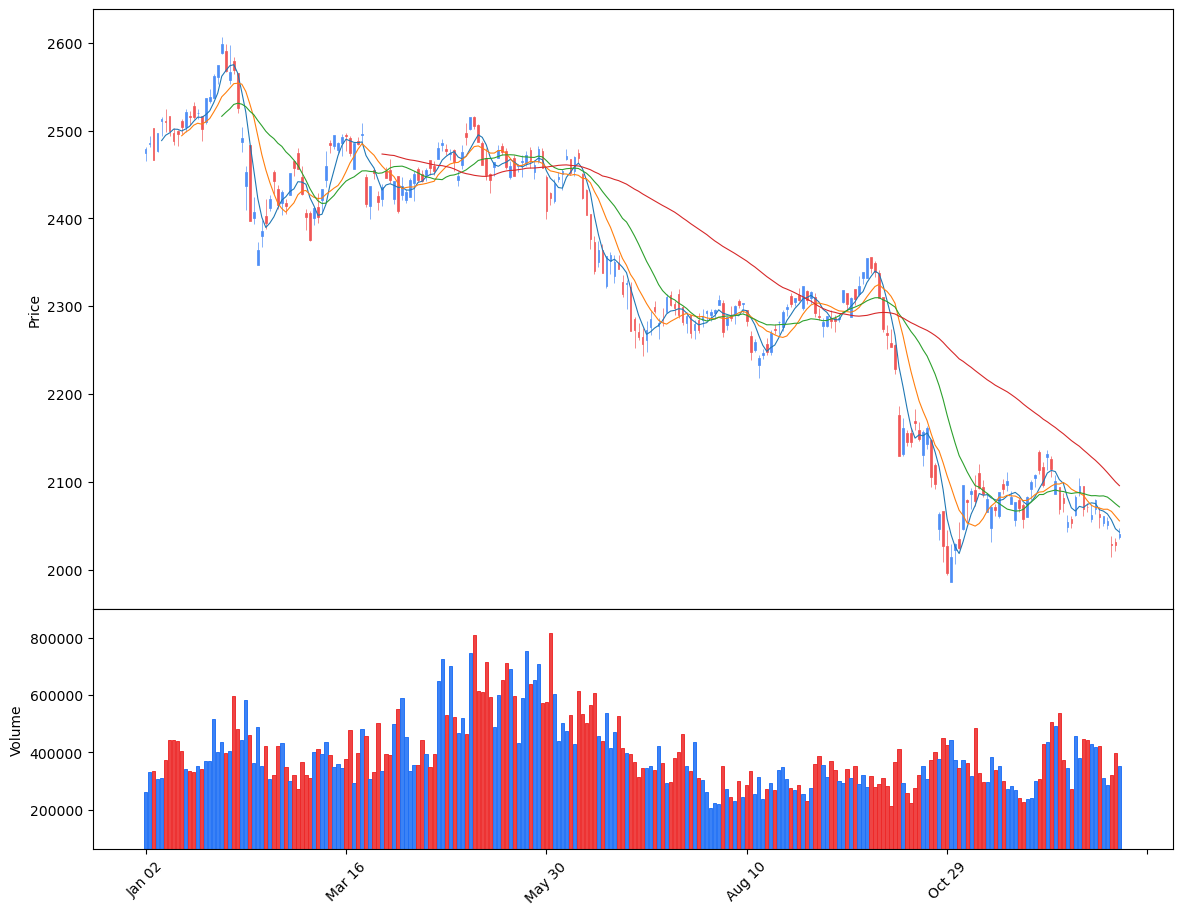

In [35]:
one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-30")]

mpf_mc = mpf.make_marketcolors(
    up=colors[10],
    down=colors[0],
    inherit=True
)

mpf_style = mpf.make_mpf_style(marketcolors=mpf_mc)

mpf.plot(one_year_df, type="candle", style=mpf_style, mav=(5, 10, 20, 60), volume=True, figsize=(15, 12))

In [36]:
def rsi(df, n=14):
    close = df["Close"]
    delta = close.diff()[1:]
    
    prices_up = delta.copy()
    prices_down = delta.copy()
    
    prices_up[prices_up < 0] = 0
    prices_down[prices_down > 0] = 0
    
    roll_up = prices_up.rolling(n).mean()
    roll_down = prices_down.abs().rolling(n).mean()
    
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [37]:
def create_features(df):
    df = df.drop(columns=["Open", "High", "Low", "Adj Close"])
    
    df["EMA_9"] = df["Close"].ewm(9).mean().shift()
    
    sma_periods = [5, 10, 20, 30, 60]
    
    for period in sma_periods:
        df[f"SMA_{period}"] = df["Close"].rolling(period).mean().shift()
        
    df["RSI"] = rsi(df).fillna(0)

    EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

    df["MACD"] = pd.Series(EMA_12 - EMA_26)
    df["MACD_signal"] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    
    df = df.loc[df.index >= "2001-01-01"]
    
    return df

In [100]:
df_raw = df.copy()
df = create_features(df)
df.tail()

,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_20,SMA_30,SMA_60,RSI,MACD,MACD_signal
Date,,,,,,,,,,,
2022-11-21,2419.500000,544500.0,2389.020957,2463.961963,2440.043970,2366.085486,2315.427335,2333.246667,64.740424,47.070267,42.168531
2022-11-22,2405.270020,539200.0,2392.068861,2452.931982,2444.814966,2375.252490,2321.649333,2332.982666,61.458788,42.403405,42.215506
2022-11-23,2418.010010,474800.0,2393.388977,2437.919971,2445.437964,2383.762488,2328.755998,2332.279667,64.635917,39.280097,41.628424
2022-11-24,2441.330078,481200.0,2395.851080,2426.031982,2444.797973,2392.184985,2335.940666,2331.292167,65.102753,38.245715,40.951883
2022-11-25,2437.860107,438400.0,2400.398980,2425.718018,2448.707983,2399.812488,2345.222664,2330.630501,61.483650,36.722647,40.106035


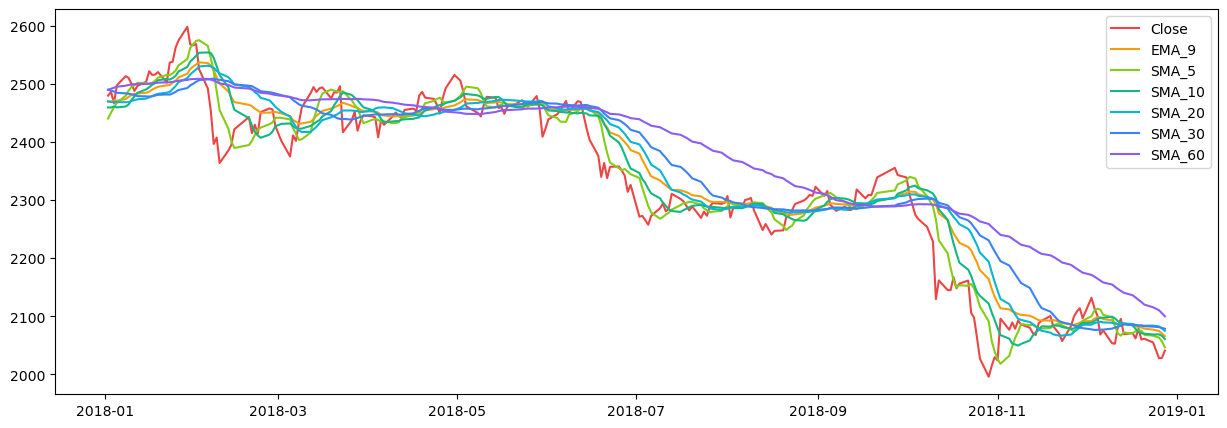

In [101]:
one_year_df = df.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

plt.plot(one_year_df["Close"], color=color_pal[0], label="Close")
plt.plot(one_year_df["EMA_9"], color=color_pal[2], label="EMA_9")
plt.plot(one_year_df["SMA_5"], color=color_pal[4], label="SMA_5")
plt.plot(one_year_df["SMA_10"], color=color_pal[6], label="SMA_10")
plt.plot(one_year_df["SMA_20"], color=color_pal[8], label="SMA_20")
plt.plot(one_year_df["SMA_30"], color=color_pal[10], label="SMA_30")
plt.plot(one_year_df["SMA_60"], color=color_pal[12], label="SMA_60")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

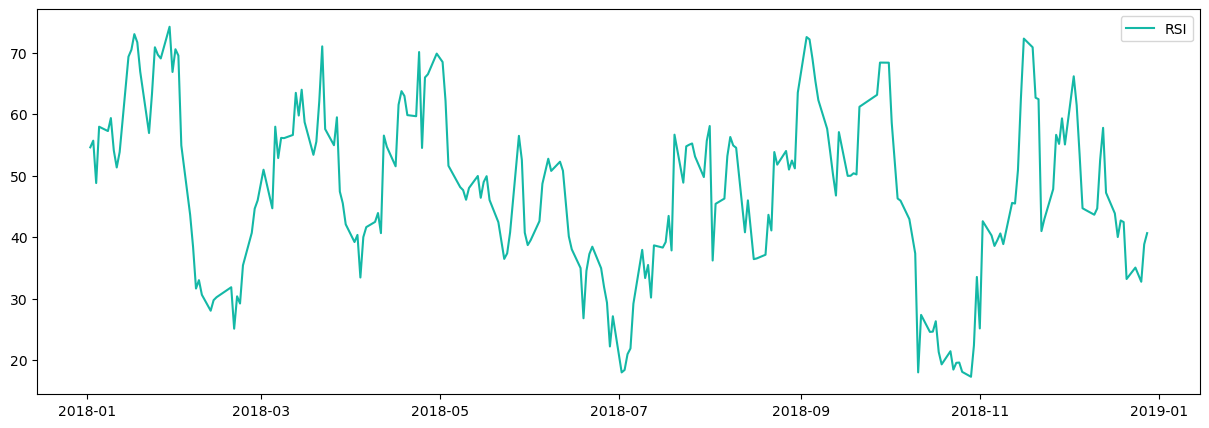

In [42]:
plt.plot(one_year_df["RSI"], color=color_pal[7], label="RSI")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

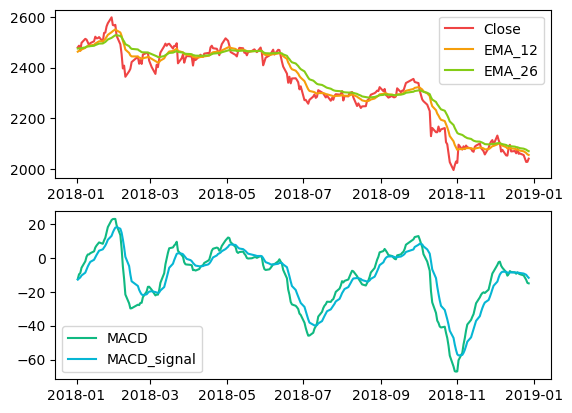

In [44]:
EMA_12 = pd.Series(df["Close"].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df["Close"].ewm(span=26, min_periods=26).mean())

one_year_EMA_12 = EMA_12.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]
one_year_EMA_26 = EMA_26.loc[(df.index >= "2018-01-01") & (df.index <= "2018-12-31")]

fix, axs = plt.subplots(2)

axs[0].plot(one_year_df["Close"], color=color_pal[0], label="Close")
axs[0].plot(one_year_EMA_12, color=color_pal[2], label="EMA_12")
axs[0].plot(one_year_EMA_26, color=color_pal[4], label="EMA_26")
axs[0].legend()

axs[1].plot(one_year_df["MACD"], color=color_pal[6], label="MACD")
axs[1].plot(one_year_df["MACD_signal"], color=color_pal[8], label="MACD_signal")
axs[1].legend()

fig.set_size_inches(20, 10, forward=True)

In [45]:
train_df = df.loc[df.index < "2018-01-01"].copy()
valid_df = df.loc[("2018-01-01" <= df.index) & (df.index < "2019-07-01")].copy()
test_df = df.loc[("2019-07-01" <= df.index) & (df.index < "2021-01-01")].copy()

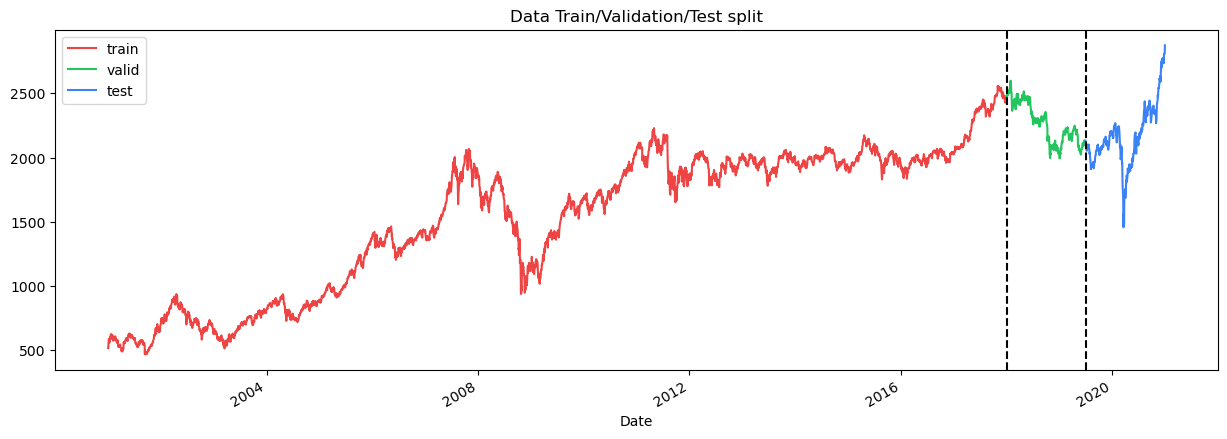

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.Close.plot(ax=ax, color=color_pal[0], label="train", title="Data Train/Validation/Test split")
valid_df.Close.plot(ax=ax, color=color_pal[5], label="valid")
test_df.Close.plot(ax=ax, color=color_pal[10], label="test")
ax.axvline("2018-01-01", color="black", ls="--")
ax.axvline("2019-07-01", color="black", ls="--")
plt.legend()
plt.show()

In [47]:
y_train = train_df["Close"].copy()
X_train = train_df.drop(["Close"], axis=1)

y_valid = valid_df["Close"].copy()
X_valid = valid_df.drop(["Close"], axis=1)

y_test = test_df["Close"].copy()
X_test = test_df.drop(["Close"], axis=1)

In [48]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

In [67]:
param = {
    "n_estimators": 1000,
    "force_col_wise": "true",
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 70,
    "min_data_in_leaf": 60,
    "tree_learner": "serial",
    "device_type": "cpu",
    "seed": 100,
    "max_depth": 7,
    "metric": "l2",
    "subsample": 1.0,
    "verbose": 0,
}

tss = TimeSeriesSplit(5)
folds = tss.split(X_train)
cv_res_gen = lgb.cv(
    param, lgb_train, folds=folds, callbacks=[lgb.early_stopping(20)]
)
cv_res_obj = lgb.cv(
    param, lgb_train, folds=tss, callbacks=[lgb.early_stopping(20)]
)

np.testing.assert_allclose(cv_res_gen["l2-mean"], cv_res_obj["l2-mean"])


c:\Users\thinl\scoop\apps\miniconda3\current\envs\ai-final\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [68]:
model = lgb.train(param, lgb_train, 1000, lgb_valid, callbacks=[lgb.early_stopping(20)])

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Users\thinl\scoop\apps\miniconda3\current\envs\ai-final\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [69]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [70]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

print(f"MSE: {mse}, R2 Score: {r2}")

MSE: 8098.407194674494, R2 Score: 0.8582663162085146


In [125]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis=1)
final_result.columns = ['Close', 'Predict']
final_result.index = y_test.index

final_result

,Close,Predict
Date,,
2019-07-01,2129.739990,2111.430707
2019-07-02,2122.020020,2109.703900
2019-07-03,2096.020020,2101.204667
2019-07-04,2108.729980,2109.703900
2019-07-05,2110.590088,2103.295270
...,...,...
2020-12-23,2759.820068,2462.890606
2020-12-24,2806.860107,2462.890606
2020-12-28,2808.600098,2462.890606


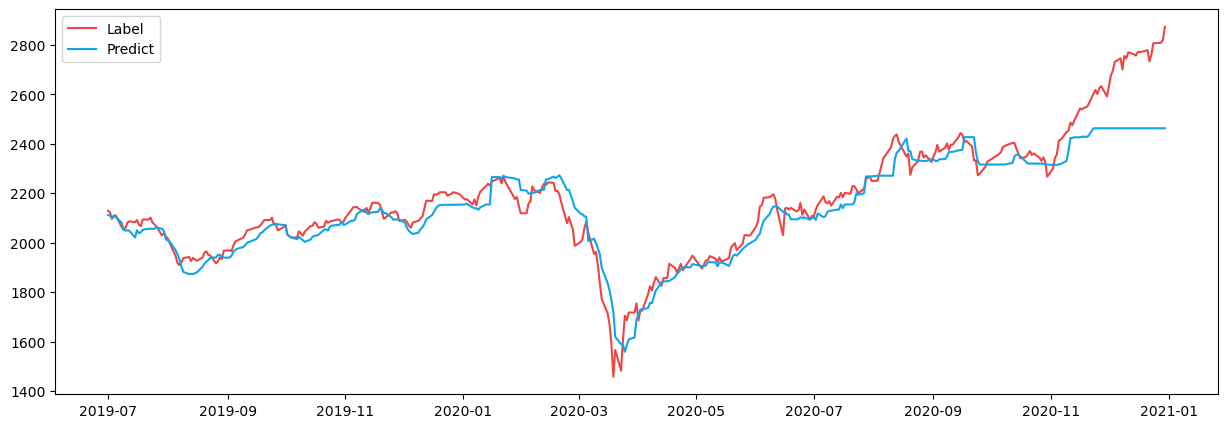

In [75]:
plt.plot(final_result["Close"], color=color_pal[0], label="Label")
plt.plot(final_result["Predict"], color=color_pal[9], label="Predict")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)

In [126]:
from statistics import mean

def backtest(backtest_df):
    backtest_df["Open"] = df_raw["Open"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]
    backtest_df["High"] = df_raw["High"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]
    backtest_df["Low"] = df_raw["Low"].loc[("2019-07-01" <= df_raw.index) & (df_raw.index < "2021-01-01")]
    
    for i in range(3, 22, 2):
        backtest_df[f"ma_{i}"] = backtest_df["Close"].rolling(i).mean().shift()

    backtest_df["ma_score"] = 0
    for i in range(3, 22, 2):
        backtest_df["ma_score"] += np.where(backtest_df[f"ma_{i}"] < backtest_df["Close"], 0.1, 0)

    return backtest_df.loc[backtest_df.index >= "2019-07-30"]

final_result = backtest(final_result.copy())

In [127]:
final_result.head()

,Close,Predict,Open,High,Low,ma_3,ma_5,ma_7,ma_9,ma_11,ma_13,ma_15,ma_17,ma_19,ma_21,ma_score
Date,,,,,,,,,,,,,,,,
2019-07-30,2038.680054,2046.576558,2035.319946,2044.589966,2032.609985,2056.739990,2070.793994,2077.381452,2075.682237,2077.771839,2078.671556,2075.569352,2076.958841,2079.634226,2084.038586,0.0
2019-07-31,2024.550049,2013.429203,2036.459961,2041.160034,2010.949951,2044.806681,2058.240015,2069.427159,2071.877808,2073.790028,2075.448477,2074.679354,2072.728839,2076.616333,2079.702398,0.0
2019-08-01,2017.339966,2009.022239,2015.089966,2032.229980,2009.329956,2030.903361,2046.690015,2059.600010,2067.211141,2067.670022,2070.670795,2072.397355,2070.398258,2072.185810,2075.060971,0.0
2019-08-02,1998.130005,2004.147353,1995.310059,2005.310059,1987.119995,2026.856690,2035.262012,2047.584298,2058.653347,2062.617298,2065.660025,2068.181348,2068.357666,2067.277909,2071.314302,0.0
2019-08-05,1946.979980,1969.729369,1985.930054,1987.640015,1945.390015,2013.340007,2021.636011,2035.560006,2048.074449,2056.397294,2058.449247,2062.279354,2064.790017,2063.802124,2066.047636,0.0
